<img src="logo.png" width="300" height="300" align="center"/>

# GenoML Demo for IPDGC London Workshop 2019

## Details
- **Put together by:** Hampton Leonard, Mary Makarious, and Mike Nalls
- **Project:** GenoML Demo for IPDGC London 2019 
- **PIs:** Mike Nalls, PhD and Andrew Singleton, PhD from the Laboratory of Neurogenetics NIH/NIA/NINDS
- **Collaborators:** Full list of collaborators [here](https://genoml.github.io/)
- **Date Last Updated:** 12.17.2019
	- Last Update: Added interpretation of results 

## Description + Objective 

## Table of Contents
### [0. Getting Started](#0)
 1. ???
 2. ???
 
### [1. Data Munging](#1)
 1. ???
 2. ???
 
### [2. Training the Model](#2)
 1. ???
 2. ???
 
### [3. Tuning the Model](#3)
 1. ???
 2. ???
 
 
### [4. Interpreting Results](#5)
 1. ???
 2. ???

<a id="0"></a>
## Part 0: Getting Started 

In [1]:
# Import the necessary packages 
import os
import sys
import argparse
import math
import time
import h5py
import joblib
import subprocess
import numpy as np
import pandas as pd

# Additional packages for VIF calculation
import random
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from joblib import Parallel, delayed

# Additional packages for training
import xgboost
import sklearn
import seaborn as sns

# Additional packages for tuning
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_randfloat

# Viewing Images
from IPython.display import Image

In [2]:
# Check the platform to load the right PLINK to path
    # This will load a PLINK v1.9 which is necessary for data munging 
    # If running this in Docker/Binder - nothing to worry about :) 
from sys import platform
def get_platform():
    platforms = {
        "linux" : "linux",
        "linux1" : "linux",
        "linux2" : "linux",
        "darwin" : "mac"
    }
    if sys.platform not in platforms:
        return "GenoML is not supported on this platform. Please try Mac or Linux"
    elif platforms[sys.platform] == "mac":
        filename_mac = "plink/mac/"
        directory_mac = os.getcwd() + "/" + filename_mac
        os.environ["PATH"] = os.environ["PATH"] + os.pathsep + directory_mac
    else:
        filename_linux = "plink/linux/"
        directory_linux = os.getcwd() + "/" + filename_linux
        os.environ["PATH"] = os.environ["PATH"] + os.pathsep + directory_linux
    return print("PLINK has successfully been loaded to your path!")

# Run and get the proper PLINK to path
get_platform()

# Set seed for reproducibility!
random.seed(981234546)

PLINK has successfully been loaded to your path!


<a id="1"></a>
## Part 1: Data Munging

### Brief Overview:
In this section we will look at how GenoML munges and cleans the data. 
The data being used in this demo are not real individuals or SNPs

### What we will look at in this section:
1. What the input files look like 
    - Phenotype file
    - PLINK binaries 
2. How to run the GenoML munging scipt 
    - How to glance at the script
    - How to submit a command 
    - How to tweak the inputs 
 

In [3]:
# Let's have a look at what the input files look like 
    # 1 = case
    # 0 = control 
pheno_file = pd.read_csv("example_inputs/training_pheno.csv")
pheno_file.head()

,ID,PHENO
0,sample1,1
1,sample2,1
2,sample3,1
3,sample4,0
4,sample5,0


In [4]:
# What about how the geno files look like?
    # These are standard PLINK binaries 
geno_bim = pd.read_csv("example_inputs/training.bim", delimiter='\t')
geno_fam = pd.read_csv("example_inputs/training.fam")

print("Here is a glimpse of what the bim file (with the SNP info) looks like")
print(geno_bim.head())

print()
print("Here is a glimpse of what the fam file (with the sex amd phenotype info) looks like")
print(geno_fam.head())

print()
print("The .bed file is a binary file - so no need to look at it now :) ")

Here is a glimpse of what the bim file (with the SNP info) looks like
   1  snp410  0  10638604  T  C
0  1  snp403  0  12013215  T  C
1  1  snp164  0  15857302  C  T
2  1  snp363  0  15903085  T  G
3  1  snp439  0  16306012  G  C
4  1  snp370  0  16326935  A  G

Here is a glimpse of what the fam file (with the sex amd phenotype info) looks like
     sample81 sample81 0 0 2 1
0  sample158 sample158 0 0 1 2
1  sample216 sample216 0 0 2 2
2    sample36 sample36 0 0 1 1
3  sample346 sample346 0 0 2 2
4  sample274 sample274 0 0 2 1

The .bed file is a binary file - so no need to look at it now :) 


In [5]:
%run -i ./scripts/munging.py\
--prefix ./example_outputs/test_discrete_geno\
--pheno ./example_inputs/training_pheno.csv\
--geno ./example_inputs/training\
--vif 5\
--iter 1


Here is some basic info on the command you are about to run.
Python version info...
3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
CLI argument info...
The output prefix for this run is ./example_outputs/test_discrete_geno and will be appended to later runs of GenoML.
Working with genotype data? ./example_inputs/training
Working with additional predictors? nope
Where is your phenotype file? ./example_inputs/training_pheno.csv
Any use for an external set of GWAS summary stats? nope
If you plan on using external GWAs summary stats for SNP filtering, we'll only keep SNPs at what P value? 0.001
How strong is your VIF filter? 5
How many iterations of VIF filtering are you doing? 1
The imputation method you picked is using the column median to fill in any remaining NAs.
Give credit where credit is due, for this stage of analysis we use code from the great contributors to python packages: os, sys, argparse, numpy, pandas, joblib, math and time. We also use PLI

<a id="2"></a>
## Part 2: Training the Model


Here is some basic info on the command you are about to run.
Python version info...
3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
CLI argument info...
Are you ranking features, even though it is pretty slow? Right now, GenoML runs general recursive feature ranking. You chose to run this part.
Working with dataset ./example_outputs/test_discrete_geno from previous data munging efforts.
Give credit where credit is due, for this stage of analysis we use code from the great contributors to Python packages: argparse, xgboost, sklearn, pandas, numpy, time, matplotlib and seaborn.
As a note, in all exported probabilities and other graphics, case status is treated as a 0 or 1, with 1 representing a positive case.


Your data looks like this (showing the first few lines of the left-most and right-most columns)...
##############################
         snp292_A    snp66_T    snp134_T    snp269_G    snp190_A  snp202_G  \
count  100.000000  100.00000  100.000000 

/Users/leonardhl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
./scripts/training.py:125: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN/(TN+FN)
/Users/leonardhl/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/leonardhl/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Log Loss: 0.5836
Runtime in seconds: 0.02215

##############################
MLPClassifier
AUC: 46.0227%
Accuracy: 63.3333%
Balanced Accuracy: 43.1818%
Log Loss: 0.9505
Runtime in seconds: 0.08808

##############################
KNeighborsClassifier
AUC: 38.0682%
Accuracy: 60.0000%
Balanced Accuracy: 44.8864%
Log Loss: 2.878
Runtime in seconds: 0.01411

##############################
QuadraticDiscriminantAnalysis
AUC: 50.5682%
Accuracy: 56.6667%
Balanced Accuracy: 50.5682%
Log Loss: 14.97
Runtime in seconds: 0.01894

##############################
BaggingClassifier
AUC: 58.2386%
Accuracy: 63.3333%
Balanced Accuracy: 55.1136%
Log Loss: 0.6304
Runtime in seconds: 0.02585

##############################
XGBClassifier
AUC: 51.1364%
Accuracy: 66.6667%
Balanced Accuracy: 53.4091%
Log Loss: 0.7805
Runtime in seconds: 0.2294

##############################

This table below is also logged as ./example_outputs/test_discrete_geno.training_withheldSamples_performanceMetrics.csv and is in your cur

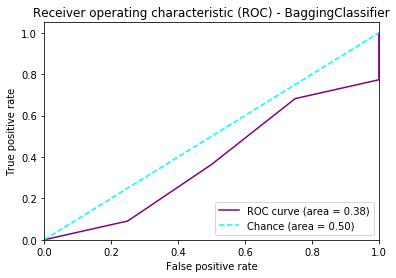

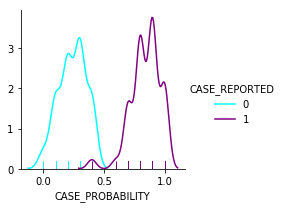

In [6]:
%run -i ./scripts/training.py\
--prefix ./example_outputs/test_discrete_geno\
--rank-features run

<a id="3"></a>
## Part 3: Tuning the Model

In [7]:
%run -i ./scripts/tuning.py\
--prefix ./example_outputs/test_discrete_geno\
--max-tune 10\
--n-cv 3

# FIXME: Module not callable error?

Here is some basic info on the command you are about to run.
Python version info...
3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
CLI argument info...
Working with the dataset and best model corresponding to prefix ./example_outputs/test_discrete_geno the timestamp from the merge is the prefix in most cases.
Your maximum number of tuning iterations is 10 and if you are concerned about runtime, make this number smaller.
You are running 3 rounds of cross-valdiation, and again... if you are concerned about runtime, make this number smaller.
Give credit where credit is due, for this stage of analysis we use code from the great contributors to python packages: argparse, xgboost, sklearn, pandas, numpy, time, matplotlib and seaborn.
As a note, in all exported probabilities and other graphics, case status is treated as a 0 or 1, with 1 representing a positive case.


Your data looks like this (showing the first few lines of the left-most and right-most columns

/Users/leonardhl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/leonardhl/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/leonardhl/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


<a id="5"></a>
## Part 4: Interpreting the Results

### General output from running GenoML:

1. test_discrete_geno.best_algorithm.txt
2. test_discrete_geno.trainedModel.joblib
3. test_discrete_geno.trainedModel_trainingSample_featureImportance.csv
4. test_discrete_geno.trainedModel_trainingSample_Predictions.csv
5. test_discrete_geno.trainedModel_withheldSample_Predictions.csv
6. test_discrete_geno.trainedModel_withheldSample_probabilities.png
7. test_discrete_geno.trainedModel_withheldSample_ROC.png
8. test_discrete_geno.training_withheldSamples_performanceMetrics.csv

#### best_algorithm.txt stores the name of the top performing algorithm

In [8]:
best_alg = pd.read_csv("example_outputs/test_discrete_geno.best_algorithm.txt")
best_alg

,QuadraticDiscriminantAnalysis


#### trainedModel.joblib is your trained model, load it using joblib.load to use it again

In [40]:
model = joblib.load("example_outputs/test_discrete_geno.trainedModel.joblib")
print(model)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


#### Model_trainingSample_featureImportance.csv contains your feature rankings, if you've chosen to rank features when training your model

In [41]:
feat_imp = pd.read_csv("example_outputs/test_discrete_geno.trainedModel_trainingSample_featureImportance.csv")
feat_imp.sort_values(by="RANK")

,RANK,FEATURE
406,1,snp446_C
147,1,snp354_C
298,1,snp448_T
150,1,snp83_G
151,1,snp351_T
152,1,snp353_C
153,1,snp497_A
291,1,snp4_G
290,1,snp384_A
156,1,snp88_C


The snps above with rank 1 make the largest contributions to the model, the snps near the bottom of the above dataframe make the smallest contributions.

This can be used for manual feature selection, remove the features contributing the least to the model and train again.

#### trainedModel_trainingSample_Predictions.csv contains predictions for the data the model is trained on - this is by nature overfit

#### test_discrete_geno.trainedModel_withheldSample_Predictions.csv is more inportant, this contains predictions for the withheld data - effectively estimating how the model would perform on unseen data

In [11]:
train_pred = pd.read_csv("example_outputs/test_discrete_geno.trainedModel_trainingSample_Predictions.csv")
train_pred[1:10]

,ID,CASE_REPORTED,CASE_PROBABILITY,CASE_PREDICTED
1,sample48,1,1.0,1
2,sample86,1,1.0,1
3,sample29,0,0.0,0
4,sample94,0,0.0,0
5,sample6,1,1.0,1
6,sample67,1,1.0,1
7,sample66,1,1.0,1
8,sample36,0,0.0,0
9,sample17,1,1.0,1


In [10]:
test_pred = pd.read_csv("example_outputs/test_discrete_geno.trainedModel_withheldSample_Predictions.csv")
test_pred[1:10]

,ID,CASE_REPORTED,CASE_PROBABILITY,CASE_PREDICTED
1,sample54,1,0.0,0
2,sample71,1,0.0,0
3,sample46,1,1.0,1
4,sample45,1,1.0,1
5,sample40,1,0.0,0
6,sample23,1,1.0,1
7,sample81,0,0.0,0
8,sample11,1,1.0,1
9,sample1,1,1.0,1


#### trainedModel_withheldSample_probabilities.png is a visualization of how prediction probabilities for witheld samples are distributed

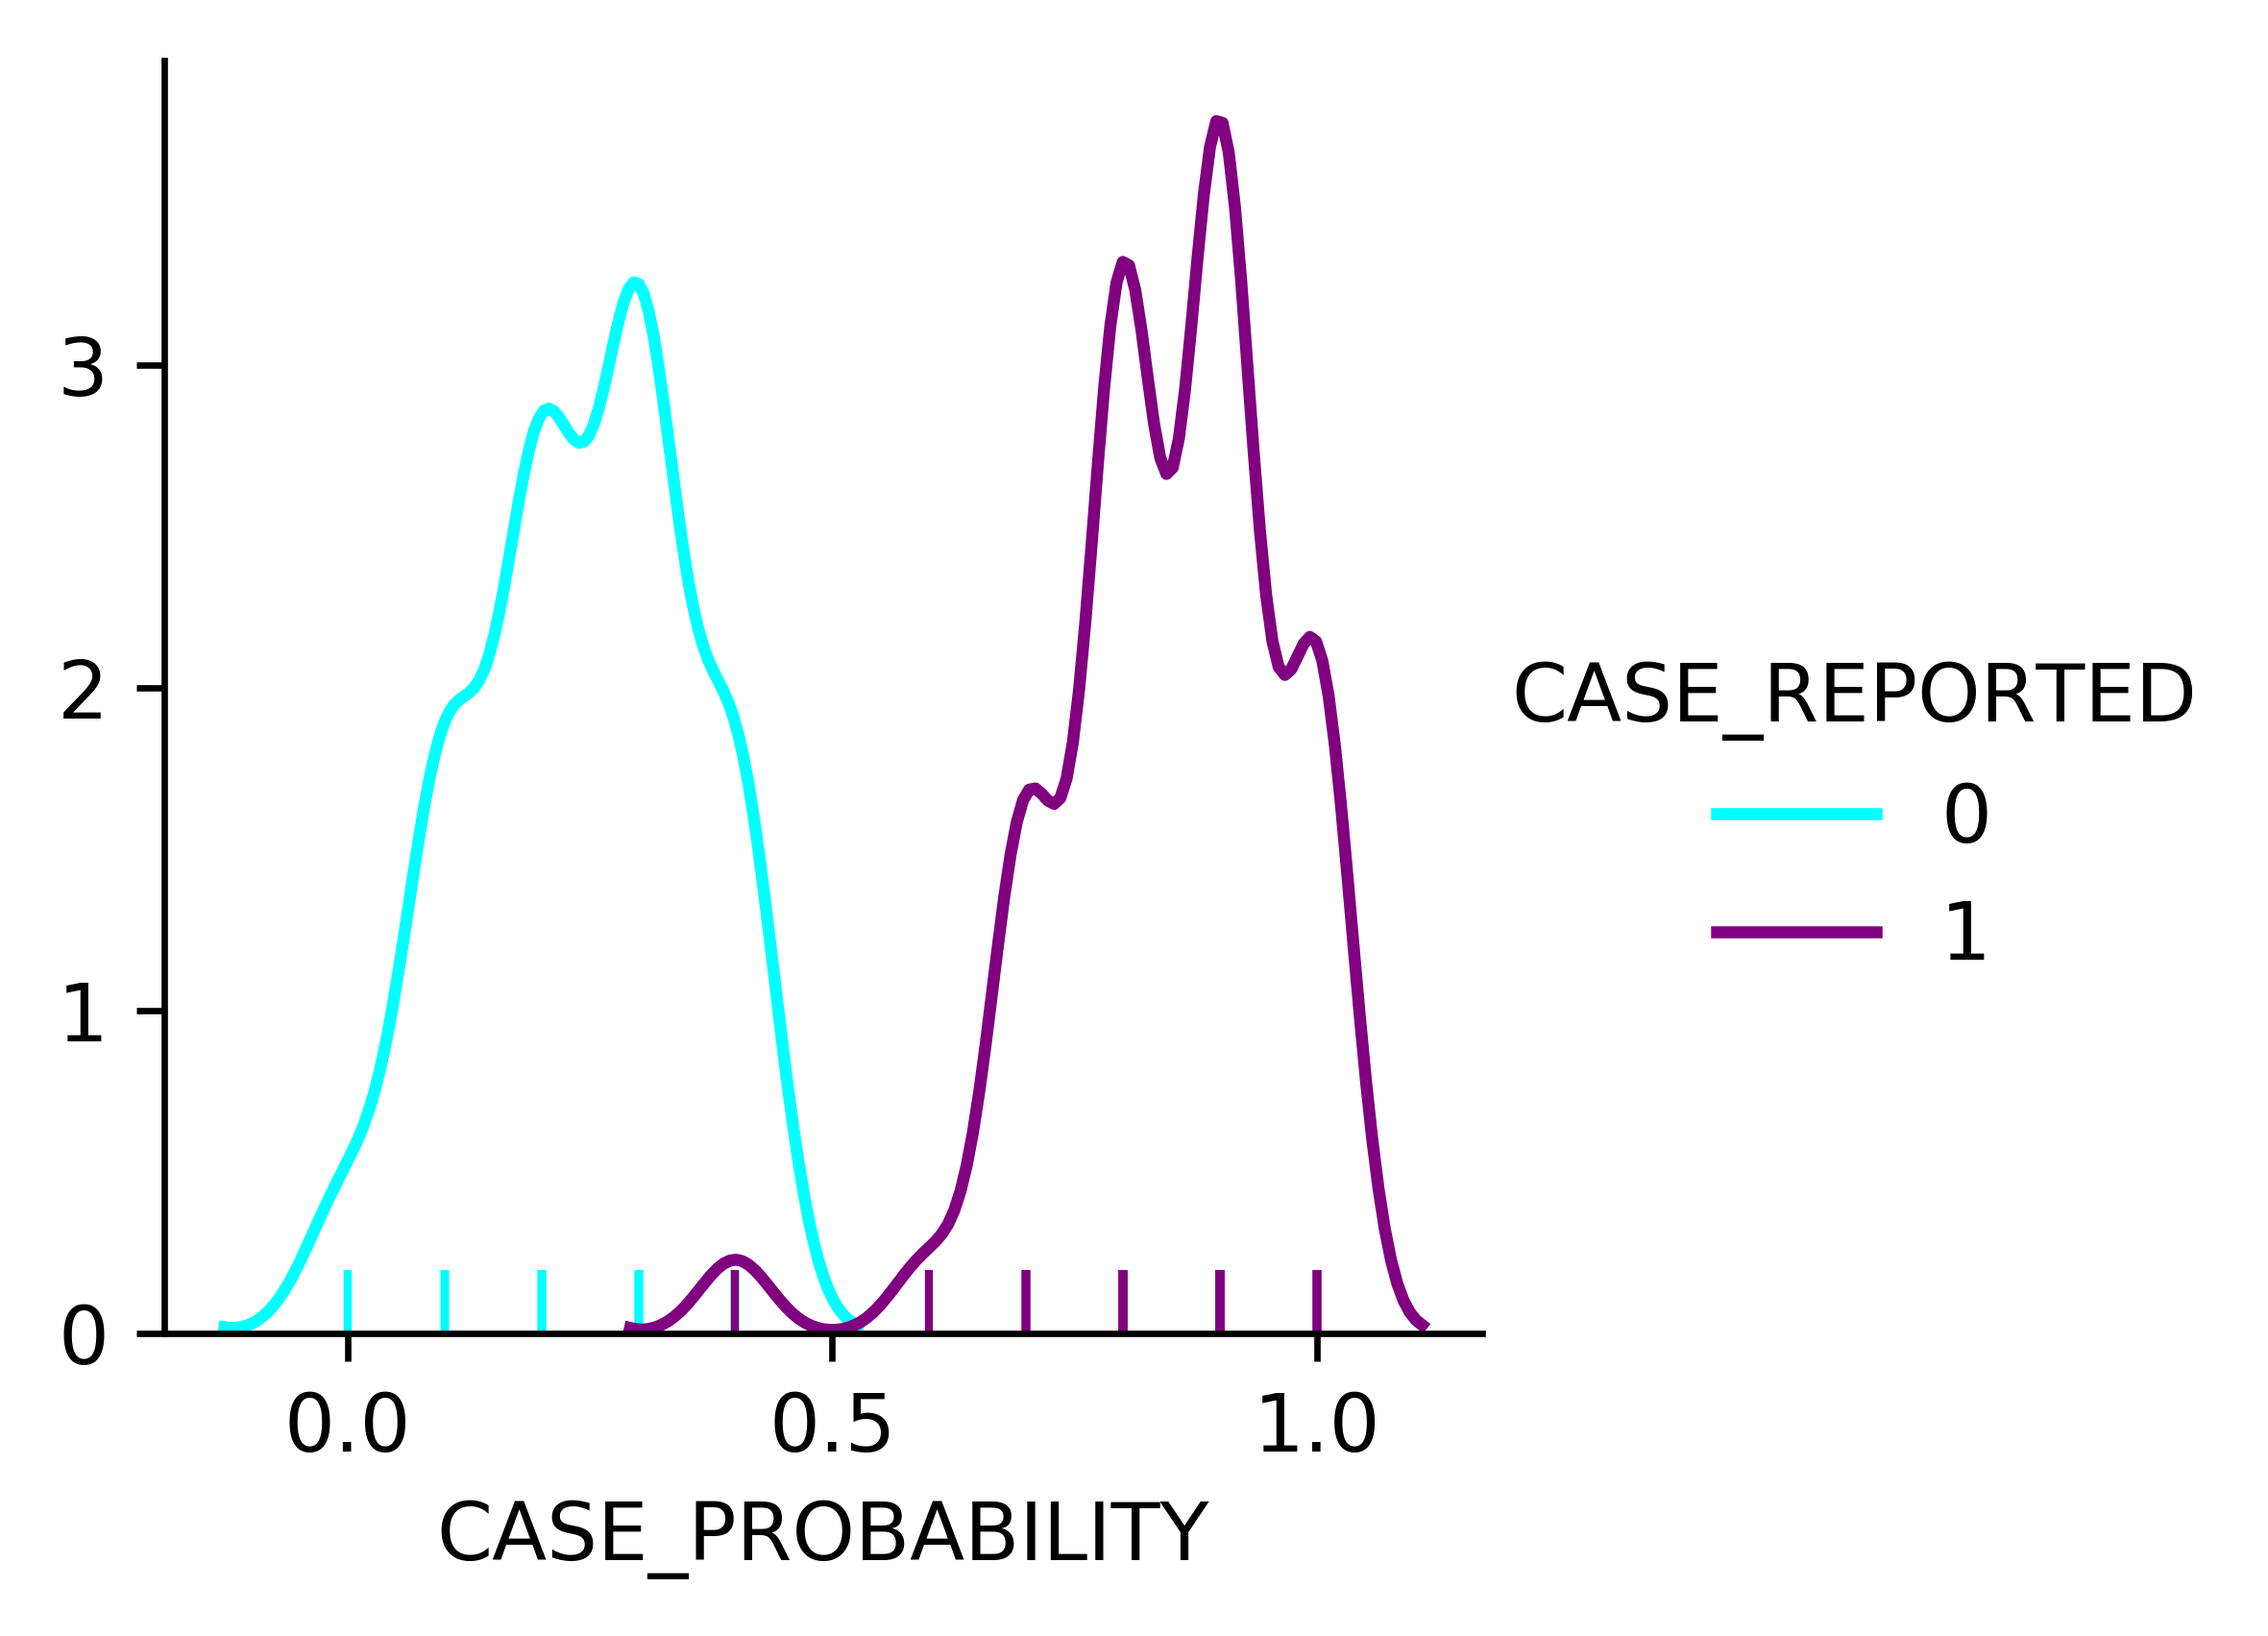

In [7]:
Image(filename="example_outputs/test_discrete_geno.trainedModel_withheldSample_probabilities.png") 

#### trainedModel_withheldSample_ROC.png displays the ROC curve for your model (the true positive rate vs the false positive rate for predictions made by your model on withheld data)

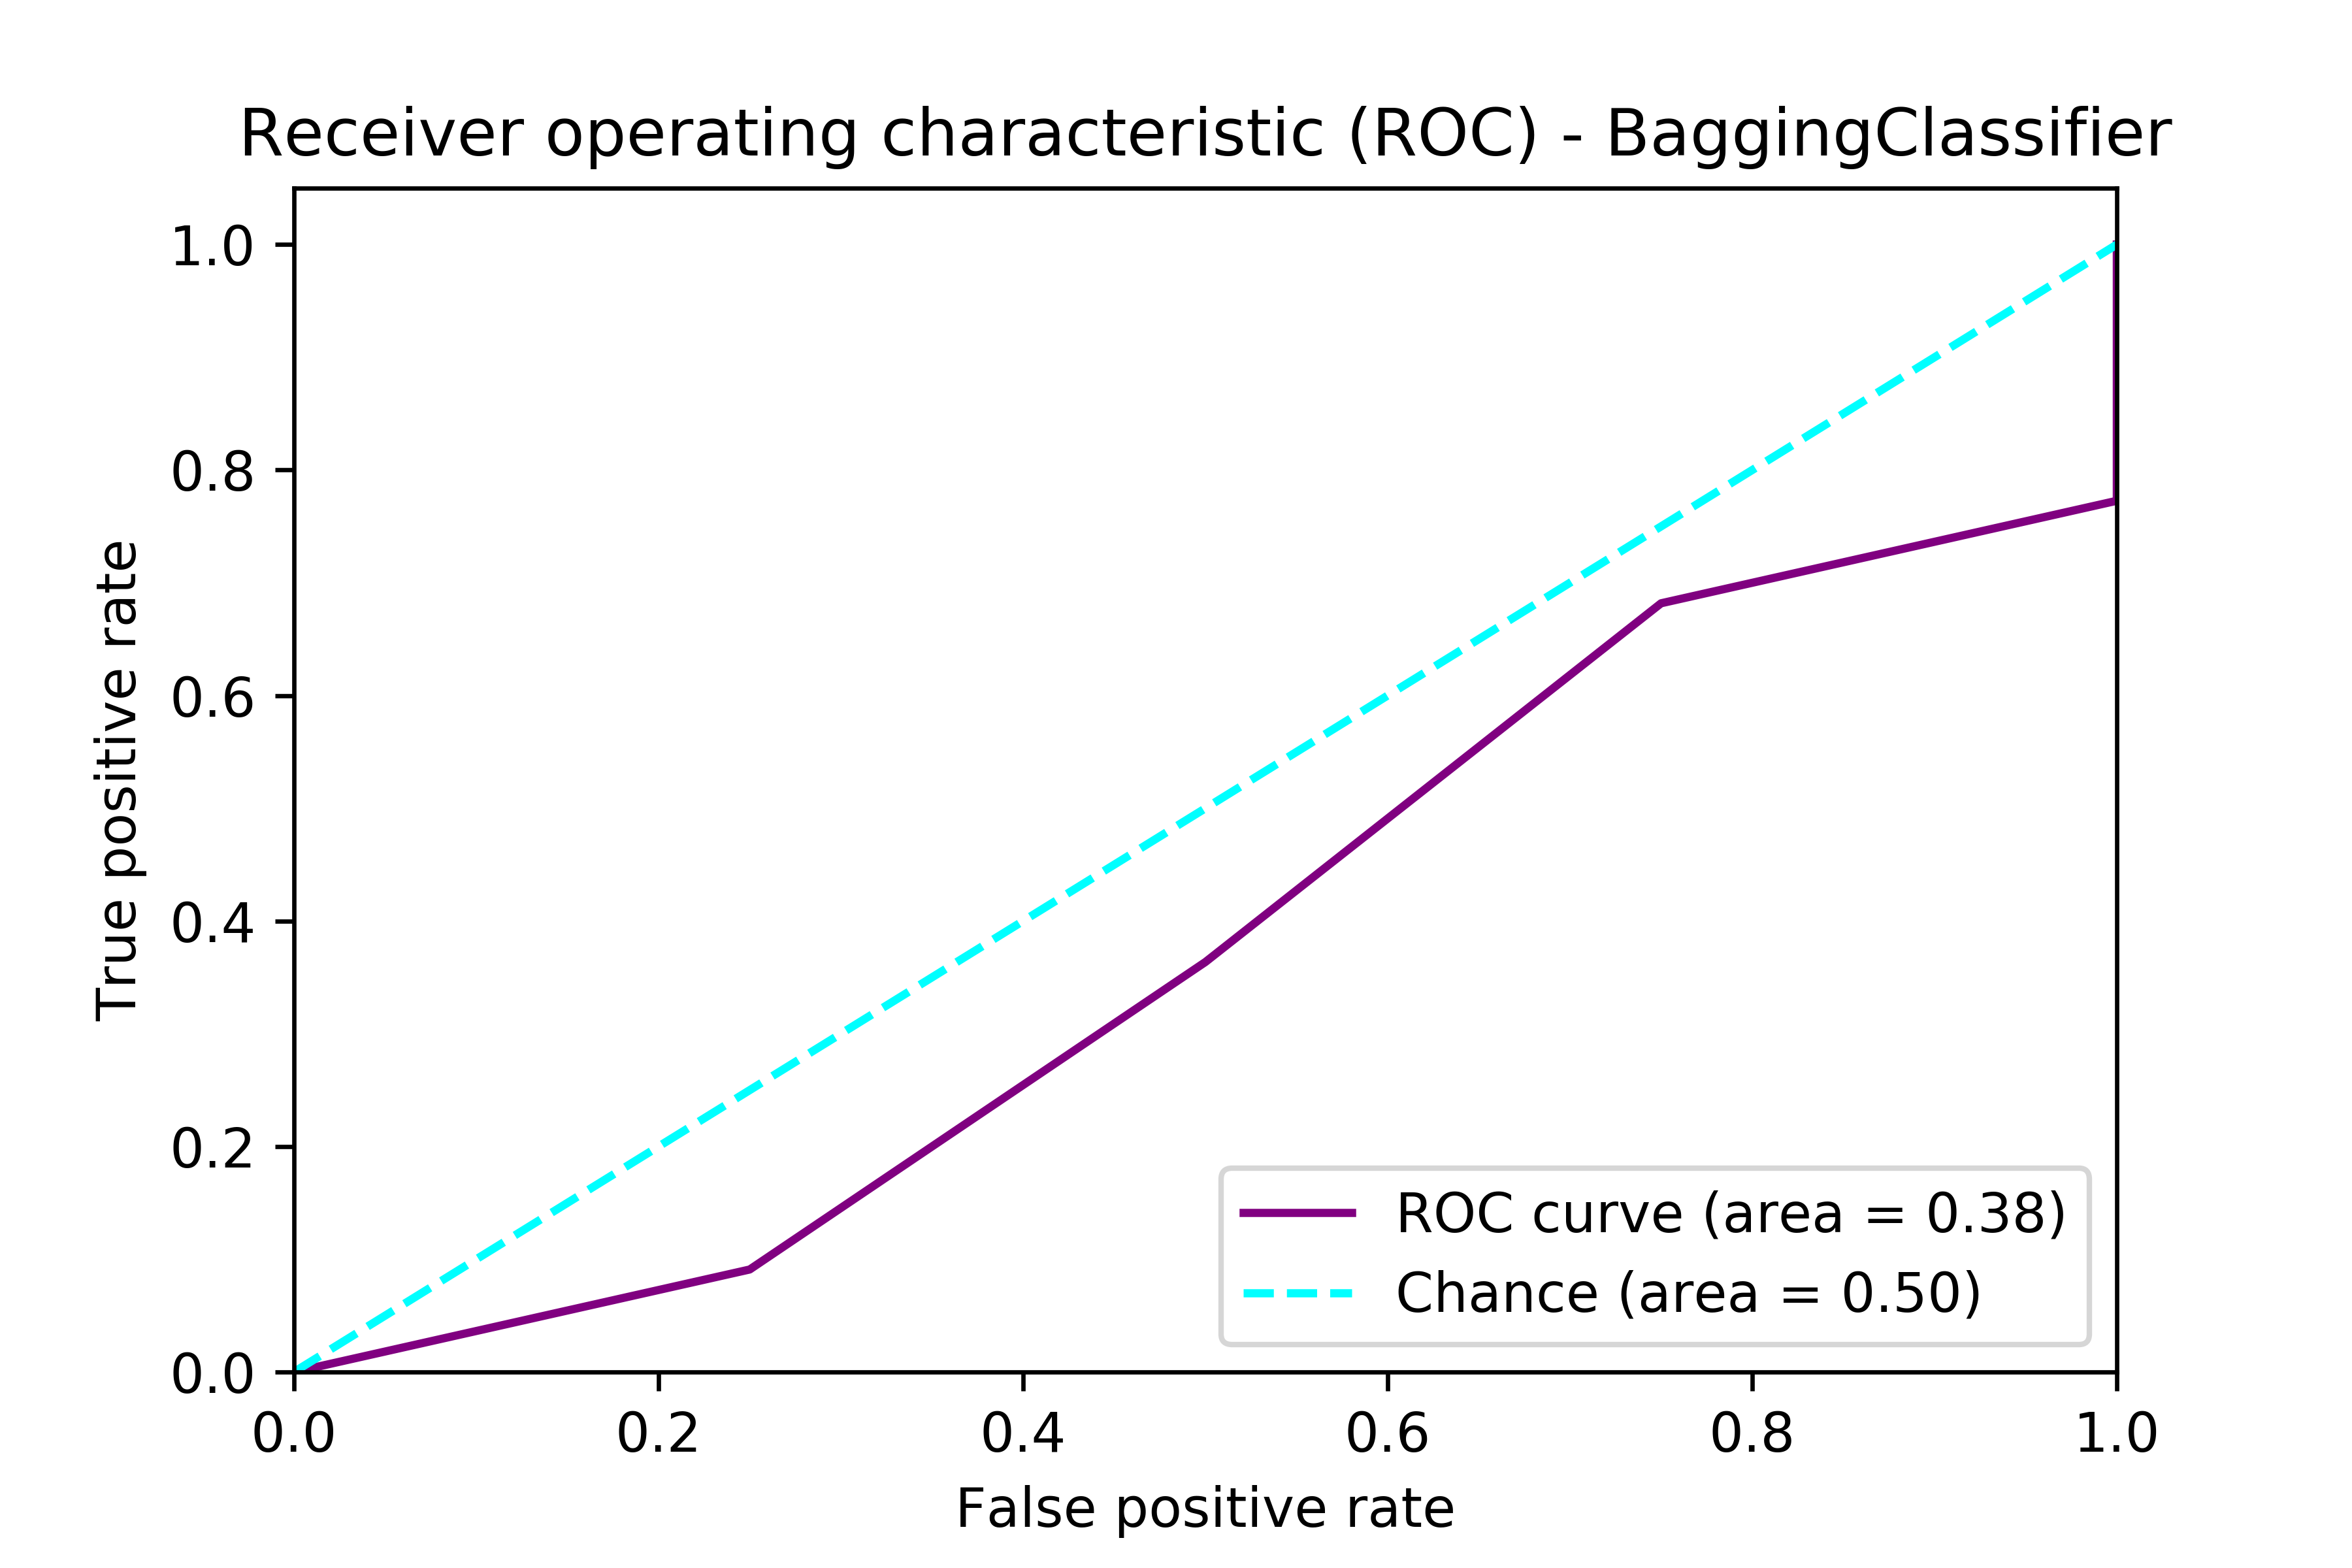

In [8]:
Image(filename="example_outputs/test_discrete_geno.trainedModel_withheldSample_ROC.png") 

#### training_withheldSamples_performanceMetrics.csv summarizes performance for all models tested in terms of metrics such as AUC, sensitivity, specificity, and more

In [9]:
metrics = pd.read_csv("example_outputs/test_discrete_geno.training_withheldSamples_performanceMetrics.csv")
metrics

,Algorithm,AUC_Percent,Accuracy_Percent,Balanced_Accuracy_Percent,Log_Loss,Sensitivity,Specificity,PPV,NPV,Runtime_Seconds
0,LogisticRegression,50.568182,63.333333,43.181818,0.805640,0.863636,0.000,0.703704,0.000000,0.029198
1,RandomForestClassifier,49.147727,56.666667,42.613636,0.635800,0.727273,0.125,0.695652,0.142857,0.030165
2,AdaBoostClassifier,55.681818,60.000000,56.818182,0.660945,0.636364,0.500,0.777778,0.333333,0.112529
3,GradientBoostingClassifier,34.659091,66.666667,49.431818,1.046900,0.863636,0.125,0.730769,0.250000,0.132865
4,SGDClassifier,43.181818,63.333333,43.181818,12.664218,0.863636,0.000,0.703704,0.000000,0.010719
5,SVC,51.136364,73.333333,50.000000,0.583587,1.000000,0.000,0.733333,NaN,0.022147
6,MLPClassifier,46.022727,63.333333,43.181818,0.950493,0.863636,0.000,0.703704,0.000000,0.088084
7,KNeighborsClassifier,38.068182,60.000000,44.886364,2.877772,0.772727,0.125,0.708333,0.166667,0.014110
8,QuadraticDiscriminantAnalysis,50.568182,56.666667,50.568182,14.966803,0.636364,0.375,0.736842,0.272727,0.018940
9,BaggingClassifier,58.238636,63.333333,55.113636,0.630396,0.727273,0.375,0.761905,0.333333,0.025850


<a id="4"></a>
## Part 5: Kipoi 

### Kipoi: Model zoo for Genomics

A repository for predictive models in genomics, facilitates easy application of models to new data and creation of new derived models

Primary goal is lowering the entry barrier to modeling genomics

https://kipoi.org